
# Quantum Key Distribution 




## Introduction


When Alice and Bob want to communicate a secret message (such as Bob's online banking details) over an insecure channel(such as the Internet), it is essential to encrypt the message. We weill beleive that Alice and Bob having a secret ket that no one else knows is useful and allows them to comunicate using the symmetric-key cryptography.

If Alice and Bob want to use Eve's classical communication channel to share their key, it is impossible to tell if Eve has made a copy of this key for herself. If, however, Eve provides a quantum communication channel, Alice and Bob no longer need to trust Eve at all- they will know if she tries to read Bob's message before it gets to Alice.

An example of a classical channel could be a telephone line: we send electric signals through the line that represents our message. A proposed example of a quantum communication channel could be some kind of fibre-optics cable, through which we can send individual photons.
Photons have a property called Polarisation, and this polarisation can be one of the two states. We can use them to represent the qubit.

## Protocol Overview

The protocol makes use of the fact that measuring a qubit can change its state. If Alice sends Bob a qubit, and an eavesdropper(Eve) tries to measure it before Bob does, there is a chance that Eve's measurement will change the state of the qubit and Bob will not recieve the qubit state Alice sent.

In [7]:
# importing necessary packages

from qiskit import QuantumCircuit, Aer, transpile,assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np

If Alice prepared a qubit in the state $|+\rangle$ and Bob measures it in the $H$-basis, Bob is sure to measure 0

┌───┐ ░ ┌───┐┌─┐
q_0: ┤ H ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c: 1/══════════════╩═
                   0

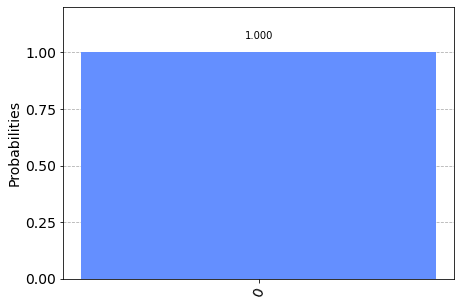

In [10]:
qc = QuantumCircuit(1,1) 
qc.h(0)                      # alice prepares qubit in state |+>
qc.barrier()                 # alice now sends the qubit to Bob
                             # who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

display(qc.draw())           # draw and simulate the circuit
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

But if Eve tries to measure this qubit in the $H$-basis before it reaches Bob, she will change the qubit's state from $|+\rangle$ to either $|0\rangle$ or $|1\rangle$, and Bob is no longer certain to measure 0

┌───┐┌─┐ ░ ┌───┐┌─┐
q_0: ┤ H ├┤M├─░─┤ H ├┤M├
     └───┘└╥┘ ░ └───┘└╥┘
c: 1/══════╩══════════╩═
           0          0

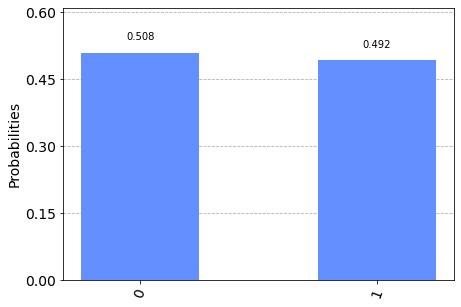

In [12]:
qc = QuantumCircuit(1,1)
qc.h(0)                       # alice prepares the qubit in state |+>
# alice now sens the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0,0)
qc.barrier()
# eve then passes this on to Bob
# who measures it in the H-basis
qc.h(0)
qc.measure(0,0)

# draw and Simulate circuit
display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())


We can see here that Bob has now 50% chance of measuring 1 and if he does, he and Alice will know there is something wrong with their channel.

The Quantum Key Distribution protocol involves repeating this process enough times that an eavesdropper has a negligible chance of getting away with this interception.

## How it works?

<li> Alice chooses a string of random bits, eg
    1000101011010100
   and a random choice of basis for each basis for each bit:
    ZZXZXXXZXZXXXX
    Alice keeps these two pieces of information private to herself.
    
    
<li> Alice then encodes each bit onto a string of qubits using the basis she chose; this mean each qubi is in one of the states $|0\rangle,|1\rangle,|+\rangle,|-\rangle$ chose at random.
    This message she sends to Bob.
    
    
    
<li> Bob then measures each qubit at random, for eg he might use
    XZZZXZXZXZXZZZXZ,
    And Bob keeps the measurement result private.
    
    
    
    
<li> Bob and Alice then publicly share which basis they used for each qubit. If Bob measured a qubit in the same basis Alice prepared it in, they use this to form part of their shared secret key, otherwise tehey discard the information.
    
    
    
<li> Finally, Bob and Alice share a random sample of their keys, and if the samples match, they can be sure that their transmission was succssful.

## Qiskit Example: Without Interception

To generate pseudo-random keys, we will use the randint function from numpy. 

In [13]:
np.random.seed(seed=0)

In [14]:
# let the length of the message be 100 qubit long
n = 100

Alice generates her random set of bits:

In [16]:
# alice generates bit

alice_bits = randint(2, size=n)
print(alice_bits)

[0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0
 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0
 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0]


At this moment, the set of bits 'alice_bits' is only known to Alice.

Alice choose to encode each bit on qubit in the $X$ or $H$- basis at random.
In this case "prepare in $H$ basis" is 0 and "prepare in $X$ basis" is 1


In [17]:
# create an array to tell us that which qubit is coded in which basis
alice_bases = randint(2, size = n)
print(alice_bases)

[1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0
 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1]


Alice also keeps this knowledge private.

The function encode_message, creates a list of Quantum Circuits, each representing a single qubit in Alice's message

In [20]:
def encode_message(bits, base):
    message=[]
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if base[i]==0:
            if bits[i]==0:
                pass
            else:
                qc.x(0)
        else:
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [21]:
message = encode_message(alice_bits, alice_bases)

We can see that the first bit in alices_bits is 0, and the basis she encodes this in is the  
X
 -basis (represented by 1):

In [22]:
print('bit = %i' % alice_bits[0])
print('basis = %i' % alice_bases[0])

bit = 0
basis = 1


In [23]:
message[0].draw()

┌───┐ ░ 
q_0: ┤ H ├─░─
     └───┘ ░ 
c: 1/════════

In [24]:
print('bit = %i' % alice_bits[4])
print('basis = %i' % alice_bases[4])
message[4].draw()

bit = 1
basis = 0


┌───┐ ░ 
q_0: ┤ X ├─░─
     └───┘ ░ 
c: 1/════════

This message of qubits is then sent to Bob over Eve's Quantum Channel

Bob then measures each qubit in the X or H bais at random and stores the info.

In [25]:
bob_bases = randint(2, size = n)
print(bob_bases)

[1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1
 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1
 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1]


Below, the function measure_message applies the corresponding measurement and simulates the result of measuring each qubit. We store the measurement results in bob_results.

In [26]:
def measure_message(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        qasm_sim = Aer.get_backend('qasm_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = qasm_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

In [27]:
bob_results = measure_message(message,bob_bases)

In [28]:
message[0].draw()

┌───┐ ░ ┌───┐┌─┐
q_0: ┤ H ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c: 1/══════════════╩═
                   0

Since Bob has by chance chosen to measure in the same basis Alice encoded the qubit in, Bob is guaranteed to get the result 0. For the 6th qubit (shown below), Bob's random choice of measurement is not the same as Alice's, and Bob's result has only a 50% chance of matching Alices'.

In [29]:
message[6].draw()

┌───┐ ░ ┌─┐
q_0: ┤ X ├─░─┤M├
     └───┘ ░ └╥┘
c: 1/═════════╩═
              0

In [30]:
print(bob_results)

[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]


After this, Alice reveals (through Eve's channel) which qubits were encoded in which basis:
And Bob reveals which basis he measured each qubit in:
If Bob happened to measure a bit in the same basis Alice prepared it in, this means the entry in bob_results will match the corresponding entry in alice_bits, and they can use that bit as part of their key. If they measured in different bases, Bob's result is random, and they both throw that entry away. Here is a function remove_garbage that does this for us


In [31]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

In [32]:
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
print(alice_key)

[0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0]


In [33]:
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print(bob_key)

[0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0]


Finally, Bob and Alice compare a random selection of the bits in their keys to make sure the protocol has worked correctly:

In [34]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample

In [35]:
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
alice_sample = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


In [36]:
bob_sample == alice_sample

True

In [37]:
print(bob_key)
print(alice_key)
print("key length = %i" % len(alice_key))

[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0]
[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0]
key length = 38
